In [28]:
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import math
from scipy.signal import savgol_filter


In [67]:
def parse_folder(subfolder):
    args = subfolder.split("__")
    arg_dict = {}
    for arg in args:
        if("=" in arg):
            lk,v = arg.split("=")
            k = lk.split("/")[-1]
            arg_dict[k] = v
    return arg_dict

def check_query_dict(arg_dict, query_dict):
    for k, v in query_dict.items():
        if(arg_dict[k] != v):
            return False
    return True

def load_data(data_fn):
    subfolders = [ f.path for f in os.scandir(data_fn) if f.is_dir() ]
    sub_data_fn = os.path.join(data_fn, subfolders[0])
    files = [os.path.join(sub_data_fn, f) for f in os.listdir(sub_data_fn) if os.path.isfile(os.path.join(sub_data_fn, f))]
    event_acc = EventAccumulator(files[0])
    event_acc.Reload() 
    values = [c.value for c in event_acc.Scalars("rollout/ep_rew_mean")]
    return values
    
def get_stats(trajectories):
    traj_array = np.array(trajectories)
    traj_mean = np.mean(traj_array, axis=0)
    print(traj_array.shape[0])

    traj_sde = np.std(traj_array, axis=0)/math.sqrt(traj_array.shape[0])
    return traj_mean, traj_sde
    
def load_query(tf_logdir="/Users/aidancurtis/firehose/firehosetmp", query_dicts = {}):
    subfolders = [ f.path for f in os.scandir(tf_logdir) if f.is_dir() ]
    arg_dicts = {subfolder: parse_folder(subfolder) for subfolder in subfolders}
    datas = {}
    for query_label, query_dict in query_dicts.items():
        data = []
        for folder_name, arg_dict in arg_dicts.items():
            if(check_query_dict(arg_dict, query_dict)):
                data.append(load_data(folder_name))
        # Clip all arrays to the minimum
        min_d = min([len(d) for d in data])
        datas[query_label] = get_stats([d[:min_d] for d in data])
    return datas

def plot_results(results, num_steps=5000000, smooth_values=[], extra_keys=["random", "naive", "expert"]):
    
    for ri, (mean, sde) in enumerate(results.values()):
        print(len(mean))
        smooth_mean = savgol_filter(mean, smooth_values[ri], 3)
        smooth_std = savgol_filter(sde, smooth_values[ri], 3)
        scale = num_steps//len(mean)
        plt.plot([x*scale for x in list(range(len(mean)))], smooth_mean)
        plt.fill_between([x*scale for x in list(range(len(mean)))], smooth_mean-smooth_std, smooth_mean+smooth_std, alpha=0.15)
    plt.legend(extra_keys+list(results.keys()))
    

            

## Algos

18
18
18
18
208
51
51
10000


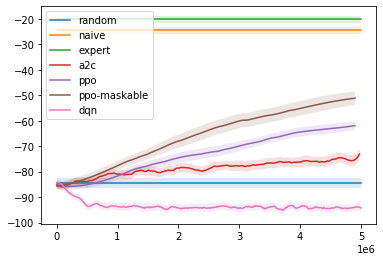

In [68]:
num_steps=5000000
baseline_runs = 1000
random = (-84.43882500000001, 59.842688532053565/math.sqrt(baseline_runs))
naive = (-24.467324999999995, 42.08832210921903/math.sqrt(baseline_runs))
expert = (-20.15715, 40.12880471217028/math.sqrt(baseline_runs))

# Accumulate seeds and get mean/std
query_dicts = {"a2c": {"algo":"a2c"}, "ppo": {"algo":"ppo"}, "ppo-maskable": {"algo":"ppo-maskable"}, "dqn": {"algo":"dqn"}}
# query_dicts = {"a2c": {"algo":"a2c"}}
smooth_values = [21, 21, 21, 501]
results = load_query(query_dicts=query_dicts)
for baseline in [random, naive, expert]:
    plt.plot([0, num_steps], [baseline[0], baseline[0]])
    plt.fill_between([0, num_steps], [baseline[0]-baseline[1], baseline[0]-baseline[1]], [baseline[0]+baseline[1], baseline[0]+baseline[1]], alpha=0.15)

plot_results(results, smooth_values=smooth_values,num_steps=num_steps)



## Gammas

6
6
6
208
208
208
6
6
6
51
51
51
6
6
6
51
51
51
6
6
6
10000
10000
10000


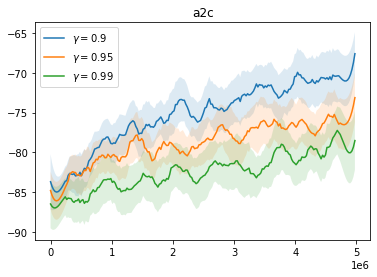

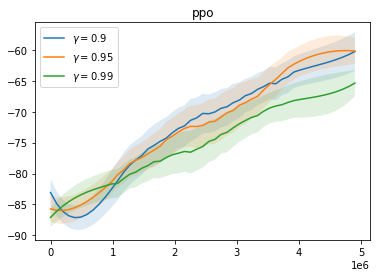

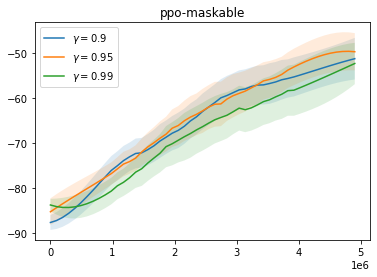

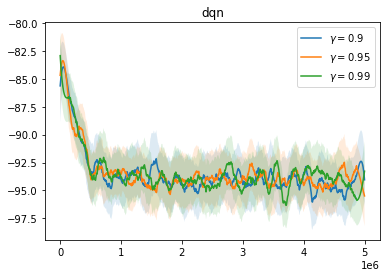

In [58]:
# Accumulate seeds and get mean/std
for algo in ["a2c", "ppo", "ppo-maskable", "dqn"]:
    plt.figure()
    query_dicts = {"$\gamma=0.9$": {"algo":algo, "gamma":"0.9"}, "$\gamma=0.95$": {"algo":algo, "gamma":"0.95"}, "$\gamma=0.99$": {"algo":algo, "gamma":"0.99"}}
    # query_dicts = {"dqn": {"algo":"dqn"}}
    if(algo == "dqn"):
        smooth_values = [501, 501, 501]
    else:
        smooth_values = [21, 21, 21]
    results = load_query(query_dicts=query_dicts)
    plot_results(results, smooth_values=smooth_values)
    plt.title(algo)


9
9
208
208
9
9
51
51
9
9
51
51
9
9
10000
10000


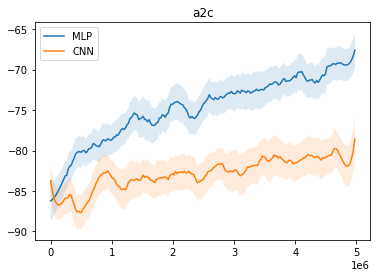

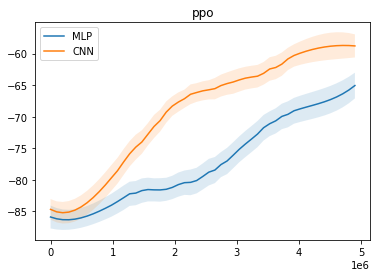

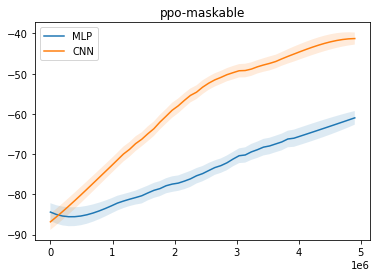

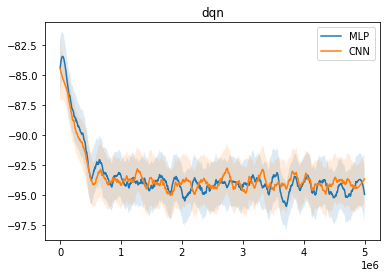

In [61]:
# Accumulate seeds and get mean/std
for algo in ["a2c", "ppo", "ppo-maskable", "dqn"]:
    plt.figure()
    query_dicts = {"MLP": {"algo":algo, "architecture":"MlpPolicy"}, "CNN": {"algo":algo, "architecture":"CnnPolicy"}}
    # query_dicts = {"dqn": {"algo":"dqn"}}
    if(algo == "dqn"):
        smooth_values = [501, 501, 501]
    else:
        smooth_values = [21, 21, 21]
    results = load_query(query_dicts=query_dicts)
    plot_results(results, smooth_values=smooth_values)
    plt.title(algo)